# $\Huge{\text{Hồi quy tuyến tính đa biến}}$

# 0. Khởi tạo ban đầu

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import pandas            as pd
import seaborn           as sns
import numpy             as np
import scipy
import math

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

np.set_printoptions(suppress=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Đọc dữ liệu từ Drive
Dữ liệu giá nhà [lấy từ Kaggle](https://www.kaggle.com/ashydv/housing-dataset)

In [ ]:
path = "/content/drive/MyDrive/Housing.csv"
cols = ['price', 'area', 'bedrooms','bathrooms', 'stories', 'mainroad',
        'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 
        'parking', 'prefarea', 'furnishingstatus']

data = pd.read_csv(path, header = 0, usecols = cols)  
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


# 2. Ánh xạ dữ liệu

### 2.1 Đánh số cho dữ liệu dạng "yes/no" và tạo biến dummy

In [ ]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
            'airconditioning', 'prefarea']

# Applying the mapping function to the housing list
data[varlist] = data[varlist].apply(lambda x: x.map({'yes': 1, 'no': 0}))

Biến giả trong tiếng Anh là Dummy variable.

Biến giả là biến độc lập được đưa vào mô hình hồi quy để giải thích các yếu tố định tính (ví dụ: giới tính, chủng tộc, tôn giáo...).

In [ ]:
# Get the dummy variables for the feature 'furnishingstatus' and store it in a
# new variable 'status'
status = pd.get_dummies(data['furnishingstatus'], drop_first = True)

# Add the results to the original housing dataframe
data = pd.concat([data, status], axis = 1)

# Drop 'furnishingstatus' as we have created the dummies for it
data.drop(['furnishingstatus'], axis = 1, inplace = True)

In [ ]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


# 3. Chia dữ liệu huấn luyện và kiểm tra


### 3.1 Chia với tỉ lệ 70% huấn luyện, 30% kiểm tra. Chuẩn hóa dữ liệu

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(
    data,
    train_size = 0.7,
    test_size = 0.3,
    random_state = 100
)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train = df_train.dropna()

### 3.2 Kiểm tra tính đa cộng tuyến

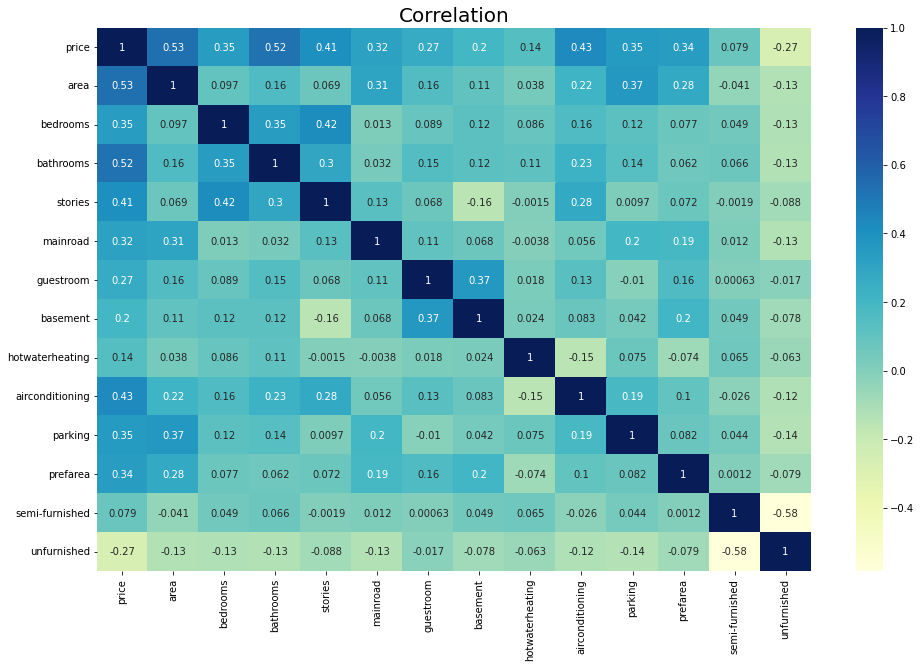

In [ ]:
# Check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
plt.title("Correlation", fontsize=20)
corr_matrix = df_train.corr()

sns.heatmap(corr_matrix, annot = True, cmap = "YlGnBu")
plt.show()

In [ ]:
corr_matrix[abs(corr_matrix) > 0.7]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
price,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stories,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mainroad,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guestroom,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
hotwaterheating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
airconditioning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


### 3.3 Lọc bớt dữ liệu bằng 1.5IQR

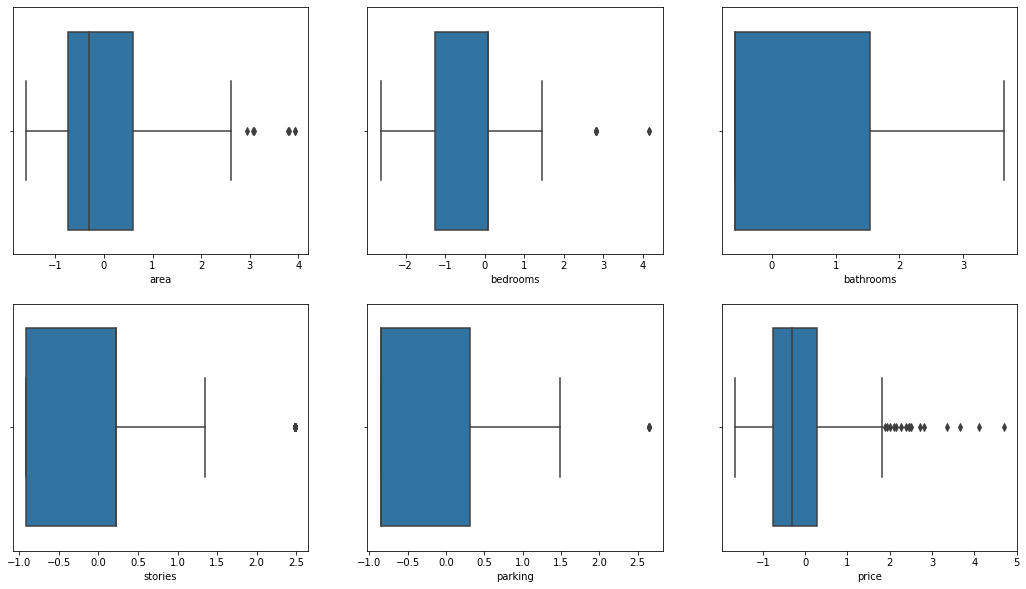

In [ ]:
columns = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']
mul = 1.7
n_rows = math.ceil(len(columns)/3)
fig, ax = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
for i, col in enumerate(columns):
    sns.boxplot(x = df_train[col], ax = ax[i//3, i%3])
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    df_train = df_train[(df_train[col] >= Q1 - mul*IQR) & (df_train[col] <= Q3 + mul*IQR)]

In [ ]:
df_train.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,-0.254241,-0.192788,-0.146605,-0.157908,-0.217875,0.833333,0.157233,0.361635,0.047170,0.238994,-0.136541,0.220126,0.430818,0.339623
std,0.723156,0.848986,0.890742,0.874863,0.734031,0.373265,0.364594,0.481231,0.212336,0.427141,0.902878,0.414984,0.495971,0.474328
min,-1.653954,-1.593480,-2.625693,-0.575844,-0.911674,0.000000,0.000000,0.000000,0.000000,0.000000,-0.848672,0.000000,0.000000,0.000000
25%,-0.780867,-0.785302,-1.266469,-0.575844,-0.911674,1.000000,0.000000,0.000000,0.000000,0.000000,-0.848672,0.000000,0.000000,0.000000
50%,-0.317852,-0.495106,0.092755,-0.575844,0.219752,1.000000,0.000000,0.000000,0.000000,0.000000,-0.848672,0.000000,0.000000,0.000000
75%,0.194256,0.428907,0.092755,-0.575844,0.219752,1.000000,0.000000,1.000000,0.000000,0.000000,0.318635,0.000000,1.000000,1.000000
max,2.003961,2.614483,1.451980,3.643319,1.351178,1.000000,1.000000,1.000000,1.000000,1.000000,1.485941,1.000000,1.000000,1.000000


In [ ]:
y_train = df_train.pop('price')
X_train = df_train

# 4. Xây dựng mô hình


### 4.1 Sử dụng bình phương cực tiểu (OLS) với tất cả biến dự đoán

In [ ]:
X_train = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     40.41
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           1.84e-58
Time:                        00:53:10   Log-Likelihood:                -188.09
No. Observations:                 318   AIC:                             404.2
Df Residuals:                     304   BIC:                             456.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5538      0.091     

*Nhận xét:*
- Theo kết quả chạy ở trên có một vài biến như 'bedrooms', 'semi-furnished' là có p-value khá lớn, có nghĩa là hệ số hồi quy tương ứng có thể là 0 (biến có thể không ảnh hưởng đến mô hình)
- Theo tiêu chuẩn Durbin-Watson các sai số không tương quan cấp 1
- F-statistic và p-value rất bé nên ta bác bỏ giả thuyết $β_1 = · · · = β_{13} = 0$


### 4.2 Chọn lọc biến dự đoán

In [ ]:
def mixed_selection(curr_preds, potential_preds, predictors, response, tol=.05):
    lm = sm.OLS(response, predictors[curr_preds]).fit()
    while potential_preds != []:
        best_pred = None                    # this will record the best predictor
        best_r_squared = lm.rsquared_adj    # record the r squared of the current model
        # loop to determine if any of the predictors can better the r-squared  
        for pred in potential_preds:
            preds = curr_preds[:] + [pred]
            new_r_squared = sm.OLS(response, predictors[preds]).fit().rsquared_adj  # record r squared for new model
            if new_r_squared > best_r_squared:
                best_r_squared = new_r_squared
                best_pred = pred

        if best_pred != None:               # a potential predictor improved the r-squared; remove it from potential_preds and add it to current_preds
            curr_preds.append(best_pred)
            potential_preds.remove(best_pred)
        else:                               # none of the remaining potential predictors improved the adjust r-squared; exit loop
            break

        # fit a new lm using the new predictors, look at the p-values
        pvals = sm.OLS(response, predictors[curr_preds]).fit().pvalues    # the two-tailed p values for the t-stats of the params.

        # remove the feature from curr_preds that have a p-value that is too large
        for feat in pvals.index:
            if pvals[feat] > tol and feat != 'const':
                curr_preds.remove(feat)
    return curr_preds

In [ ]:
curr_preds = ['const']
potential_preds = list(lm.params.index)
potential_preds.remove('const')
print(potential_preds)

['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'semi-furnished', 'unfurnished']


In [ ]:
mixed_selection(curr_preds=curr_preds, potential_preds=potential_preds,predictors=X_train, response=y_train, tol=.05)

['const',
 'area',
 'bathrooms',
 'stories',
 'unfurnished',
 'prefarea',
 'mainroad',
 'airconditioning',
 'basement',
 'hotwaterheating',
 'parking']

### 4.3 Khảo sát phần dư

In [ ]:
y_train_pred = lm.predict(X_train)    # hat y
res = y_train - y_train_pred          # hat epsilon

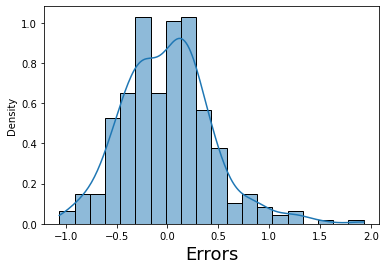

In [ ]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.histplot(res, bins = 20, kde=True, stat="density")
                 
plt.xlabel('Errors', fontsize = 18)
plt.show()

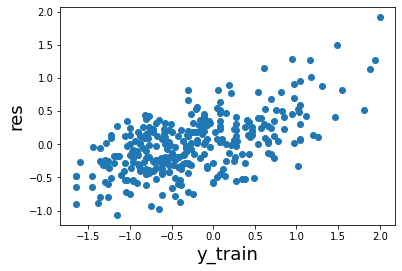

In [ ]:
plt.rcParams['text.usetex'] = False
plt.scatter(y_train,res)
plt.xlabel('y_train',  fontsize = 18)
plt.ylabel('res',  fontsize = 18)
plt.show()

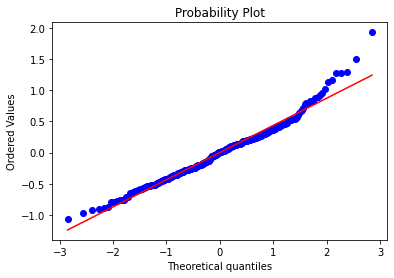

In [ ]:
import pylab 
# Q-Q plot
scipy.stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

Xét giả thuyết $H_0:$ $\varepsilon \sim N(0, σ^2In)$ hay $\hat{\varepsilon} \sim N(0, σ^2
(I − H))$

In [ ]:
from scipy.stats import t
def student_test(model, alpha):
    n = int(model.df_model + model.df_resid + 1)
    r = int(model.df_model)
    Z = np.asmatrix(X_train.copy()).reshape(n, r + 1)
    Y = np.asmatrix(y_train.copy()).reshape(n, 1)
    B = np.linalg.inv((Z.T).dot(Z)).dot(Z.T).dot(Y)
    H = Z.dot(np.linalg.inv((Z.T).dot(Z)).dot(Z.T))
    IH = np.eye(H.shape[0]) - H             # I - H
    v, e = np.linalg.eig(IH)                
    Eps = Y - Z.dot(B)                      # hat epsilon
    E = e.T.dot(Eps)                        # e = P^T.epsilon
    e_m = np.mean(E)
    e_i2 = np.sum(np.power(E, 2))           # sum of e_i^2
    T = n*e_m*np.sqrt((n-r-2)/(np.abs(n**2*e_m**2 - (n-r-1)*e_i2)))
    pt = t.ppf(1 - alpha/2, n - r - 2)
    return abs(np.asscalar(np.real(T))), pt, abs(np.asscalar(np.real(T))) > pt

Nếu kết quả trả về là 'False' thì nghĩa là $H_0$ không bị bác bỏ

In [ ]:
student_test(lm, 0.05)

(0.5651477318198039, 1.9678240977517993, False)

#### Xử lý Leverage

     dfb_const  dfb_area  dfb_bedrooms  dfb_bathrooms  dfb_stories  \
359  -0.018670 -0.035713      0.056071      -0.007636    -0.057421   
159  -0.005674 -0.072839      0.022325       0.062771    -0.065317   
267   0.001695  0.002421      0.001122      -0.004032     0.004354   
263   0.143750  0.046094     -0.001467      -0.043474     0.051039   
433  -0.026680  0.001212     -0.023582       0.012563     0.001433   

     dfb_mainroad  dfb_guestroom  dfb_basement  dfb_hotwaterheating  \
359      0.041493       0.002681     -0.034420            -0.007912   
159      0.038624       0.077673     -0.006387            -0.001187   
267      0.002803      -0.000484     -0.003966            -0.004128   
263     -0.163824      -0.002718     -0.023185            -0.029027   
433      0.028266      -0.002903      0.008762             0.006818   

     dfb_airconditioning  dfb_parking  dfb_prefarea  dfb_semi-furnished  \
359            -0.008421     0.024971     -0.011802           -0.003632   
15

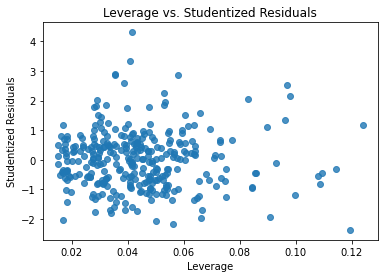

In [ ]:
influence = lm.get_influence()
inf_sum = influence.summary_frame()
print(inf_sum.head())

student_resid = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag

X_train['leverage'] = leverage
X_train['student_resid'] = student_resid

print('Leverage vs. Studentized Residuals')
sns.regplot(x = leverage, y = lm.resid_pearson, fit_reg = False)
plt.title('Leverage vs. Studentized Residuals')
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
plt.show()

In [ ]:
num_ol = X_train[abs(X_train['leverage']) > (2 * X_train.shape[1]) / X_train.shape[0]]
# Remove high Leverage points
X_train.drop([x for x in num_ol.index], inplace = True)
y_train.drop([x for x in num_ol.index], inplace = True)
X_train.drop(['leverage', 'student_resid'], axis = 1, inplace = True)

### 4.4 Chạy mô hình sau khi chọn lọc biến và loại bỏ outlier

In [ ]:
# Model after selecting a mixture of predictors and removing outliers
lm_1 = sm.OLS(y_train,X_train[curr_preds]).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     49.41
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           1.13e-57
Time:                        00:53:13   Log-Likelihood:                -186.14
No. Observations:                 312   AIC:                             394.3
Df Residuals:                     301   BIC:                             435.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4623      0.079     

*Nhận xét:*
- Dựa vào F-statistic, ta bác bỏ giả thuyết $β_1 = · · · = β_{10} = 0$

- Các p-value ứng với t-statistic trong kết quả chạy mô hình trên đều khá bé nên ta bác bỏ giả thuyết $\beta_i = 0$ với mọi $i=\overline{1, 10}$
- Theo tiêu chuẩn Durbin-Watson thì các sai số cũng không có sự tương quan cấp 1

#### Xác định khoảng tin cậy của hệ số hồi quy
Khoảng tin cậy $100(1-α)\%$ của $β_i$ được xác định bởi
$$βi ± \sqrt{(s^2(Z'Z)^{−1})_{(i+1)(i+1)}(r + 1)F_{r+1,n−r−1}(α)}$$

hoặc đơn giản hơn
$$βi ± t_{n-r-1}(α/2)\sqrt{(s^2(Z'Z)^{−1})_{(i+1)(i+1)}}$$

In [ ]:
from scipy.stats import f, t
def estimateBetaInterval(model, alpha):
    n = int(model.df_model + model.df_resid + 1)
    r = int(model.df_model)
    Z = np.asmatrix(X_train[curr_preds].copy()).reshape(n, r + 1)
    Y = np.asmatrix(y_train.copy()).reshape(n, 1)
    B = np.linalg.inv((Z.T).dot(Z)).dot(Z.T).dot(Y)
    Eps = Y - Z.dot(B)
    s2 = Eps.T.dot(Eps)/(n - r - 1)         # s^2
    ZTZ1 = np.linalg.inv(Z.T.dot(Z))        # (Z'Z)^{-1}
    pf = f.ppf(1 - alpha, r + 1, n - r - 1) # F_{r+1,n-r-1}(alpha) upper quantile
    pt = t.ppf(1 - alpha/2, n - r - 1)      # Student 

    print("beta =  beta_i ±         = [     Fisher    ] / [    Student    ]")
    print("________________________________________________________________")
    for i in range(r + 1):
        Bi = np.asscalar(B[i])
        deltaBi = np.asscalar(np.sqrt(np.asscalar(ZTZ1[i,i])*(r+1)*pf*s2))
        deltaBit = pt*np.asscalar(np.sqrt(np.asscalar(ZTZ1[i,i])*s2))
        print(f"b_{i:2d} = {Bi:7.4f} ± {deltaBi:7.4f} = [{Bi - deltaBi:7.4f};{Bi + deltaBi:7.4f}] / [{Bi - deltaBit:7.4f};{Bi + deltaBit:7.4f}]")

In [ ]:
estimateBetaInterval(lm_1, 0.05)

beta =  beta_i ±         = [     Fisher    ] / [    Student    ]
________________________________________________________________
b_ 0 = -0.4623 ±  0.3514 = [-0.8137;-0.1109] / [-0.6168;-0.3078]
b_ 1 =  0.2863 ±  0.1535 = [ 0.1329; 0.4398] / [ 0.2188; 0.3538]
b_ 2 =  0.2328 ±  0.1434 = [ 0.0894; 0.3761] / [ 0.1697; 0.2958]
b_ 3 =  0.1900 ±  0.1646 = [ 0.0255; 0.3546] / [ 0.1177; 0.2624]
b_ 4 = -0.2331 ±  0.2495 = [-0.4826; 0.0164] / [-0.3428;-0.1234]
b_ 5 =  0.2672 ±  0.2937 = [-0.0265; 0.5608] / [ 0.1380; 0.3963]
b_ 6 =  0.2638 ±  0.3296 = [-0.0658; 0.5934] / [ 0.1188; 0.4087]
b_ 7 =  0.2572 ±  0.2800 = [-0.0228; 0.5372] / [ 0.1341; 0.3803]
b_ 8 =  0.2031 ±  0.2521 = [-0.0490; 0.4551] / [ 0.0922; 0.3139]
b_ 9 =  0.4336 ±  0.6610 = [-0.2274; 1.0945] / [ 0.1429; 0.7242]
b_10 =  0.0587 ±  0.1344 = [-0.0757; 0.1932] / [-0.0004; 0.1179]


# 5. Dự báo quan sát mới

### 5.1 Chạy với tập kiểm tra

In [ ]:
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])
df_test = df_test.dropna()
y_test = df_test.pop('price')
X_test = df_test

In [ ]:
X_test = sm.add_constant(X_test)
X_test = X_test[curr_preds]

In [ ]:
X_test.head()

,const,area,bathrooms,stories,unfurnished,prefarea,mainroad,airconditioning,basement,hotwaterheating,parking
265,1.0,-0.978244,-0.565752,0.236370,0,1,1,0,0,0,-0.711709
54,1.0,0.321253,1.218544,0.236370,0,0,1,1,0,0,0.443937
171,1.0,2.099313,-0.565752,-0.975026,0,1,1,0,0,0,0.443937
244,1.0,0.038029,-0.565752,0.236370,0,1,1,0,1,0,-0.711709
268,1.0,-0.116078,-0.565752,0.236370,0,0,1,1,0,0,-0.711709


In [ ]:
y_pred = lm_1.predict(X_test)
error_term = (y_test - y_pred)

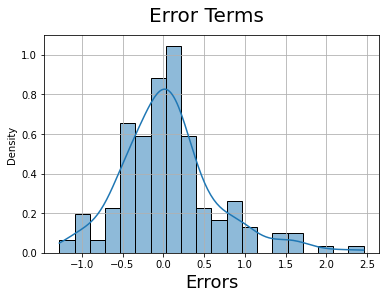

In [ ]:
fig = plt.figure()
plt.grid()
sns.histplot(error_term, bins = 20, kde=True, stat="density")
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

### 5.2 Hệ số xác định

In [ ]:
lm_1.rsquared_adj

0.6088387348437772

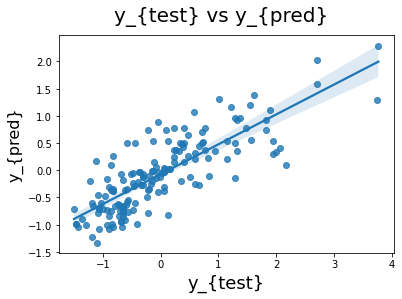

In [ ]:
plt.rcParams['text.usetex'] = False
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
sns.regplot(y_test, y_pred, fit_reg=True)
fig.suptitle(r'y_{test} vs y_{pred}', fontsize=20)              
plt.xlabel('y_{test}', fontsize=18)                          
plt.ylabel('y_{pred}', fontsize=16)
plt.show()

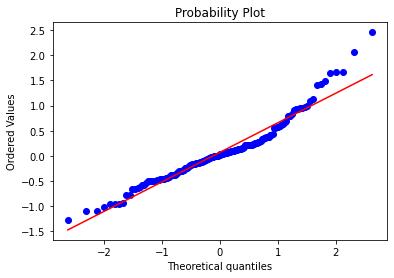

In [ ]:
# Q-Q plot
scipy.stats.probplot(error_term, dist="norm", plot=pylab)
pylab.show()

### 5.3 Các hệ số của mô hình ban đầu

In [ ]:
lm_1.params

const             -0.462298
area               0.286316
bathrooms          0.232754
stories            0.190037
unfurnished       -0.233116
prefarea           0.267150
mainroad           0.263782
airconditioning    0.257191
basement           0.203075
hotwaterheating    0.433554
parking            0.058746
dtype: float64